In [1]:
# Import packages required
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets,transforms
import numpy as np
from torch.autograd import Variable

In [2]:
transformers=transforms.Compose([
                        transforms.Resize((32, 32)),
                        transforms.ToTensor()])

In [3]:
def dataloader(train_bsize, test_bsize):
    train_dataloader=torch.utils.data.DataLoader(torchvision.datasets.MNIST(root='data',train=True,download=True,
                            transform=transformers),batch_size=train_bsize, shuffle=True)
    test_dataloader=torch.utils.data.DataLoader(torchvision.datasets.MNIST(root='data',train=False,download=True,
                            transform= transformers),batch_size=test_bsize, shuffle=True)
    return (train_dataloader,test_dataloader)


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1=nn.Conv2d(1,6,5)
        self.conv2=nn.Conv2d(6,16,5)
        self.linear1=nn.Linear(16*5*5,100)
        self.linear2=nn.Linear(100,60)
        self.linear3=nn.Linear(60,10)
        
    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(x.size()[0], -1)
        x=self.linear1(x)
        x=F.leaky_relu(x)
        x=self.linear2(x)
        x=F.leaky_relu(x)
        x=self.linear3(x)
        return x
    

In [5]:
def train_model(model,optimizer,loader,Floss):
    for b_index,(data,t) in enumerate(train_dataloader):
        #forward propagation
        optimizer.zero_grad()
        output=model(data)
        loss=Floss(output,t)
        loss.backward()
        optimizer.step()

In [6]:
def cal_loss_acc(model, loader, Floss):
    total_loss = 0
    loss_counter = 0
    correct_samples = 0
    total_samples = 0
    counter=0
    for batch in loader:
        data, target = batch
        pred = model(data)
        loss = Floss(pred, target)
        total_loss += loss.data.numpy()
        counter+=1
        for i, outputTensor in enumerate(pred):
                if torch.argmax(outputTensor) == target[i]:
                    correct_samples += 1
                total_samples += 1
    return total_loss/counter, round(correct_samples/total_samples,3)

In [7]:
def compute(model,learning_rate):
    train_loss_list=[]
    test_loss_list=[]
    train_acc_list=[]
    test_acc_list=[]
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
    epochs=20
    Floss = torch.nn.CrossEntropyLoss()
    for epoch in range(1, epochs + 1):
        train_model(model, optimizer, train_dataloader, Floss)
        train_loss, train_acc = cal_loss_acc(model, train_dataloader, Floss)
        test_loss, test_acc = cal_loss_acc(model, test_dataloader, Floss)
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print('epoch',epoch,'train loss',train_loss)
    return train_loss_list,test_loss_list,train_acc_list,test_acc_list

In [8]:
train_dataloader, test_dataloader= dataloader(400,400)
learning_rate1=0.01
model1=CNN()
b1_train_loss_list,b1_test_loss_list,b1_train_acc_list,b1_test_acc_list=compute(model1,learning_rate1)

train_dataloader1, test_dataloader1= dataloader(1024,1024)
model2=CNN()
b2_train_loss_list,b2_test_loss_list,b2_train_acc_list,b2_test_acc_list=compute(model2,learning_rate1)

epoch 1 train loss 0.4077336333195368
epoch 2 train loss 0.20225317458311717
epoch 3 train loss 0.12396633078654608
epoch 4 train loss 0.09371583633124829
epoch 5 train loss 0.07896356672048568
epoch 6 train loss 0.07269836583485206
epoch 7 train loss 0.0623346089447538
epoch 8 train loss 0.05760809638847907
epoch 9 train loss 0.05469413003573815
epoch 10 train loss 0.05077051684260368
epoch 11 train loss 0.04233952010050416
epoch 12 train loss 0.03914574323222041
epoch 13 train loss 0.0358486700616777
epoch 14 train loss 0.03409604961673419
epoch 15 train loss 0.030592227975527447
epoch 16 train loss 0.031547738270213205
epoch 17 train loss 0.034187602947155636
epoch 18 train loss 0.028032291022439797
epoch 19 train loss 0.029706094038362305
epoch 20 train loss 0.025212934371083975
epoch 1 train loss 1.489499848683675
epoch 2 train loss 0.229545854528745
epoch 3 train loss 0.13505335609118144
epoch 4 train loss 0.09368236978848775
epoch 5 train loss 0.08642707554002603
epoch 6 train l

In [9]:
b1_params = torch.nn.utils.parameters_to_vector(model1.parameters())
b2_params = torch.nn.utils.parameters_to_vector(model2.parameters())

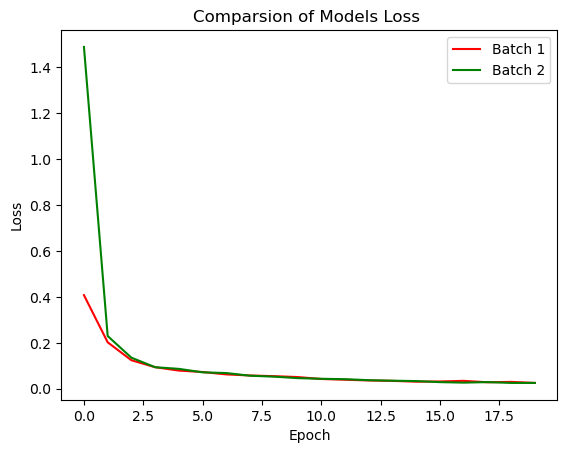

In [10]:
plt.plot(np.arange(0, 20, 1), b1_train_loss_list, color = "r")
plt.plot(np.arange(0, 20, 1), b2_train_loss_list, color = "g")
plt.title('Comparsion of Models Loss ')
plt.legend(['Batch 1', 'Batch 2'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

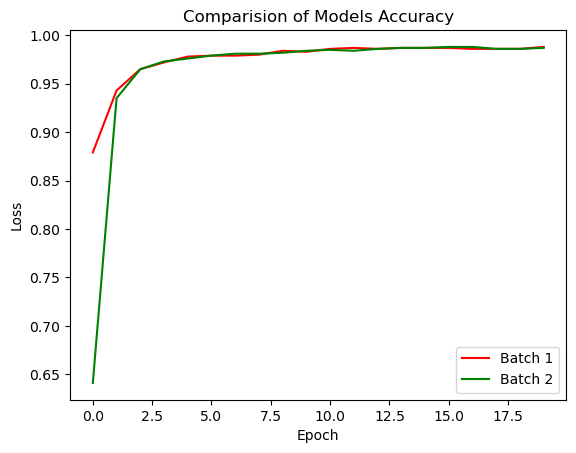

In [11]:
plt.plot(np.arange(0, 20, 1), b1_test_acc_list, color = "r")
plt.plot(np.arange(0, 20, 1), b2_test_acc_list, color = "g")
plt.title('Comparision of Models Accuracy')
plt.legend(['Batch 1', 'Batch 2'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [12]:
def cal_loss_aplha_model(alpha_val):
    alpha_train_loss_list = []
    alpha_test_loss_list = []
    alpha_train_acc_list = []
    alpha_test_acc_list = []
    counter=0
    for i in alpha_val:
        counter+=1
        theta_val=(1-i)*b1_params+i*b2_params
        model = CNN()
        torch.nn.utils.vector_to_parameters(theta_val, model.parameters())
        Floss = nn.CrossEntropyLoss()
        alpha_train_loss, alpha_train_acc = cal_loss_acc(model, train_dataloader, Floss)
        alpha_test_loss, alpha_test_acc = cal_loss_acc(model, test_dataloader, Floss)
        alpha_train_loss_list.append(alpha_train_loss)
        alpha_train_acc_list.append(alpha_train_acc)
        alpha_test_loss_list.append(alpha_test_loss)
        alpha_test_acc_list.append(alpha_test_acc)
        print('Count:',counter,' alpha_train_loss: ',alpha_train_loss)
    return alpha_train_loss_list,alpha_test_loss_list,alpha_train_acc_list,alpha_test_acc_list 

In [13]:
alpha_val=np.arange(-1.5,1.5,0.1)
alpha_train_loss_list,alpha_test_loss_list,alpha_train_acc_list,alpha_test_acc_list = cal_loss_aplha_model(alpha_val)

Count: 1  alpha_train_loss:  71.9747447458903
Count: 2  alpha_train_loss:  53.02808068593343
Count: 3  alpha_train_loss:  38.27549924214681
Count: 4  alpha_train_loss:  26.982099310557047
Count: 5  alpha_train_loss:  18.508158467610677
Count: 6  alpha_train_loss:  12.305095761617025
Count: 7  alpha_train_loss:  7.900674295425415
Count: 8  alpha_train_loss:  4.893795932928721
Count: 9  alpha_train_loss:  2.9103389406204223
Count: 10  alpha_train_loss:  1.6550474425156911
Count: 11  alpha_train_loss:  0.8921877374251683
Count: 12  alpha_train_loss:  0.4499886199831963
Count: 13  alpha_train_loss:  0.21015590521196525
Count: 14  alpha_train_loss:  0.09295530570205301
Count: 15  alpha_train_loss:  0.041320827703457325
Count: 16  alpha_train_loss:  0.025212934783970315
Count: 17  alpha_train_loss:  0.04997035220265388
Count: 18  alpha_train_loss:  0.24882815271615982
Count: 19  alpha_train_loss:  0.8914755948384603
Count: 20  alpha_train_loss:  1.6223778565724691
Count: 21  alpha_train_loss

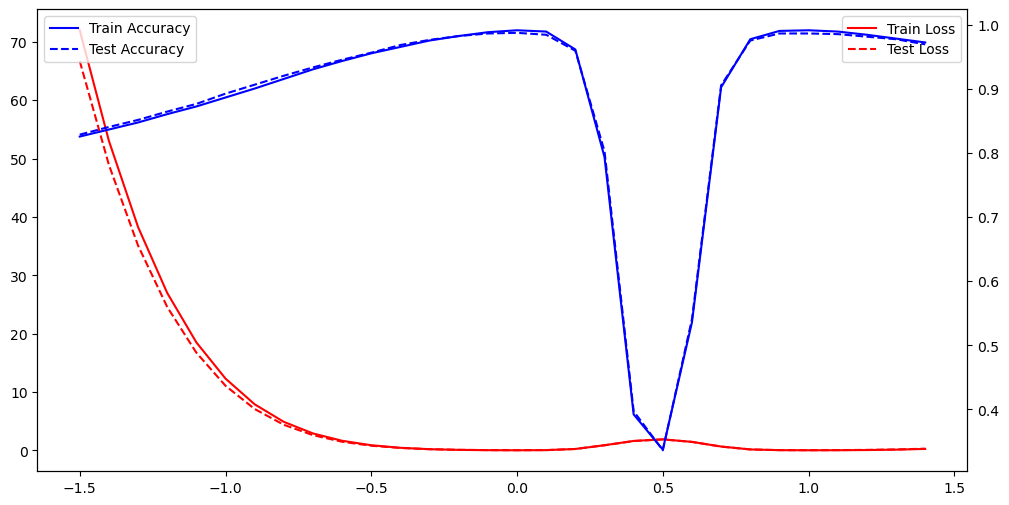

In [14]:
plt.figure(figsize=(12,6))
plt.plot(alpha_val, alpha_train_loss_list, color = "r")
plt.plot(alpha_val, alpha_test_loss_list, color = "r",linestyle='dashed')
plt.legend(['Train Loss' , 'Test Loss'])

plt.twinx()

plt.plot(alpha_val, alpha_train_acc_list, color = "b")
plt.plot(alpha_val, alpha_test_acc_list, color = "b",linestyle='dashed')
plt.legend(['Train Accuracy' , 'Test Accuracy'])

# LR=0.001

In [15]:
train_dataloader, test_dataloader= dataloader(64,64)
learning_rate1=0.001
model1=CNN()
b1_train_loss_list,b1_test_loss_list,b1_train_acc_list,b1_test_acc_list=compute(model1,learning_rate1)

train_dataloader, test_dataloader= dataloader(1024,1024)
model2=CNN()
b2_train_loss_list,b2_test_loss_list,b2_train_acc_list,b2_test_acc_list=compute(model2,learning_rate1)

epoch 1 train loss 1.409248837784155
epoch 2 train loss 0.31241112956201345
epoch 3 train loss 0.20528628977774177
epoch 4 train loss 0.15715451294909727
epoch 5 train loss 0.12886672799608537
epoch 6 train loss 0.10452833017513061
epoch 7 train loss 0.08716686226046289
epoch 8 train loss 0.08184789177496979
epoch 9 train loss 0.07188817455288349
epoch 10 train loss 0.0637646282567327
epoch 11 train loss 0.06698924314969384
epoch 12 train loss 0.05744413962500341
epoch 13 train loss 0.05042461233699063
epoch 14 train loss 0.05960664354877344
epoch 15 train loss 0.0508180865020092
epoch 16 train loss 0.04630095160976827
epoch 17 train loss 0.042960534470457674
epoch 18 train loss 0.04623869745664473
epoch 19 train loss 0.039924950739403546
epoch 20 train loss 0.03614694401734759
epoch 1 train loss 2.3013533697289934
epoch 2 train loss 2.299981812299308
epoch 3 train loss 2.2987755355188404
epoch 4 train loss 2.2974693734767073
epoch 5 train loss 2.296105174695031
epoch 6 train loss 2.29

In [16]:
b1_params = torch.nn.utils.parameters_to_vector(model1.parameters())
b2_params = torch.nn.utils.parameters_to_vector(model2.parameters())

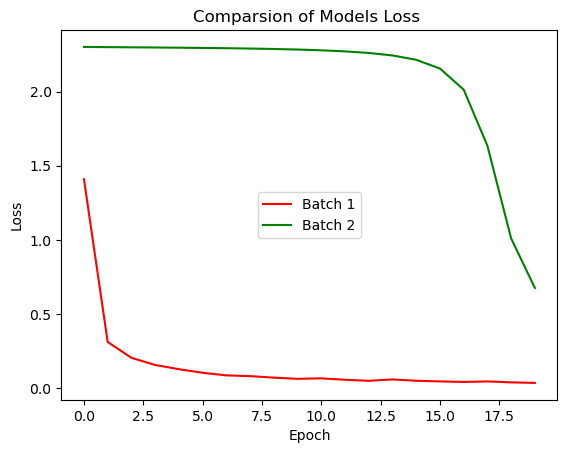

In [17]:
plt.plot(np.arange(0, 20, 1), b1_train_loss_list, color = "r")
plt.plot(np.arange(0, 20, 1), b2_train_loss_list, color = "g")
plt.title('Comparsion of Models Loss ')
plt.legend(['Batch 1', 'Batch 2'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

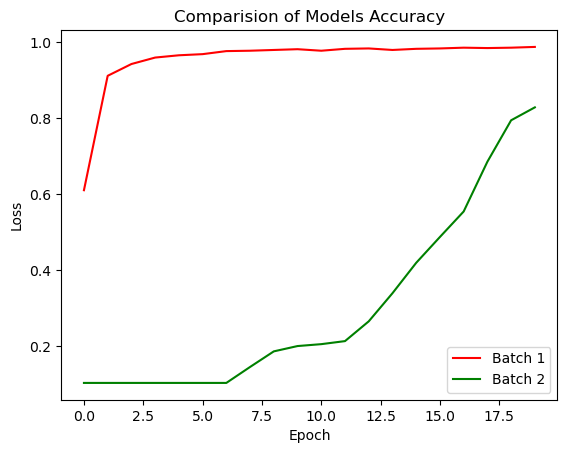

In [18]:
plt.plot(np.arange(0, 20, 1), b1_test_acc_list, color = "r")
plt.plot(np.arange(0, 20, 1), b2_test_acc_list, color = "g")
plt.title('Comparision of Models Accuracy')
plt.legend(['Batch 1', 'Batch 2'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [19]:
alpha_train_loss_list,alpha_test_loss_list,alpha_train_acc_list,alpha_test_acc_list = cal_loss_aplha_model(alpha_val)

Count: 1  alpha_train_loss:  16.34909251584845
Count: 2  alpha_train_loss:  12.240356380656614
Count: 3  alpha_train_loss:  9.030274811437575
Count: 4  alpha_train_loss:  6.5592844203367076
Count: 5  alpha_train_loss:  4.6690034947152865
Count: 6  alpha_train_loss:  3.2590740474603943
Count: 7  alpha_train_loss:  2.220086348258843
Count: 8  alpha_train_loss:  1.4757447848885745
Count: 9  alpha_train_loss:  0.946463812205751
Count: 10  alpha_train_loss:  0.5878311062263231
Count: 11  alpha_train_loss:  0.3549210004887338
Count: 12  alpha_train_loss:  0.2036334892450753
Count: 13  alpha_train_loss:  0.11363711517493603
Count: 14  alpha_train_loss:  0.06340774578058113
Count: 15  alpha_train_loss:  0.03924929678945218
Count: 16  alpha_train_loss:  0.03599861759881852
Count: 17  alpha_train_loss:  0.07293623054431657
Count: 18  alpha_train_loss:  0.2555612439321259
Count: 19  alpha_train_loss:  0.743013714329671
Count: 20  alpha_train_loss:  1.3567655995740728
Count: 21  alpha_train_loss: 

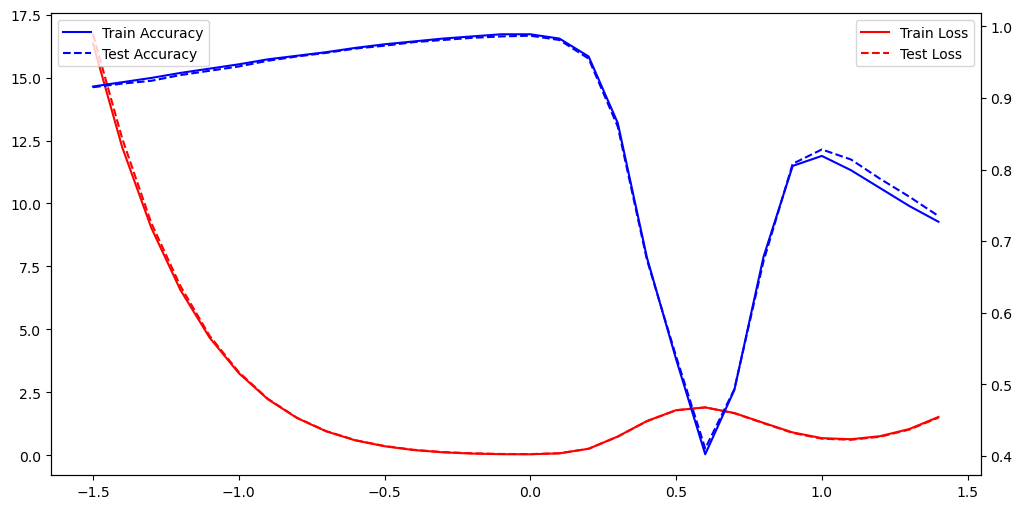

In [20]:

alpha_val=np.arange(-1.5,1.5,0.1)
plt.figure(figsize=(12,6))
plt.plot(alpha_val, alpha_train_loss_list, color = "r")
plt.plot(alpha_val, alpha_test_loss_list, color = "r",linestyle='dashed')
plt.legend(['Train Loss' , 'Test Loss'])

plt.twinx()

plt.plot(alpha_val, alpha_train_acc_list, color = "b")
plt.plot(alpha_val, alpha_test_acc_list, color = "b",linestyle='dashed')
plt.legend(['Train Accuracy' , 'Test Accuracy'],loc='upper left')